# Imports

In [180]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter,KaplanMeierFitter
import time
import requests
import sys
import pickle
import dill
import sqlite3
import http.cookiejar
import json
import matplotlib
from tableone import TableOne
import matplotlib.pyplot as plt
from pymatch.Matcher import Matcher
import math
import warnings
import matplotlib.gridspec as gridspec
from IPython.core.display import display, HTML
from scipy import interpolate
from patsy import dmatrix
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test
from lifelines.utils import interpolate_at_times_and_return_pandas
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
warnings.filterwarnings('ignore')

# Downloading RSClin Scores

This code allows for downloading of the RSClin scores from the genomichealth website. JSESSIONID must be recorded from an active session in firefox while logged into the website.

In [3]:
jsessionID = "10E0C466E2166D980EF1C9BC6638FFE5"

def get_cookies(cj, ff_cookies):
    """Get cookies from firefox

    Parameters
    ----------
    cj - cookiejar
    ff_cookies - location of firefox cookies.sqlite file
    jsessionID - JSESSIONID variable from active session
    """
    con = sqlite3.connect(ff_cookies)
    cur = con.cursor()
    cur.execute("SELECT host, path, isSecure, expiry, name, value FROM moz_cookies")
    addedSession = False
    for item in cur.fetchall():
        c = http.cookiejar.Cookie(0, item[4], item[5],
                             None, False,
                             item[0], item[0].startswith('.'), item[0].startswith('.'),
                             item[1], False,
                             item[2],
                             item[3], item[3] == "",
                             None, None, {})
        cj.set_cookie(c)
        if not addedSession and item[0] == 'rsclin.genomichealth.com':
            c = http.cookiejar.Cookie(0, "JSESSIONID", jsessionID,
                                      None, False,
                                      item[0], item[0].startswith('.'), item[0].startswith('.'),
                                      item[1], False,
                                      item[2],
                                      item[3], item[3] == "",
                                      None, None, {})

            cj.set_cookie(c)


def loadCookiesFresh():
    """Load cookies from firefox

    Returns
    ----------
    Session s with cookies loaded
    """

    cj = http.cookiejar.CookieJar()
    ff_cookies = "C:\\Users\\fhowa\\AppData\\Roaming\\Mozilla\\Firefox\\Profiles\\7s8r0vbs.default-release\\cookies.sqlite"
    get_cookies(cj, ff_cookies)
    s = requests.Session()
    s.cookies = cj
    return s

def loadCookiesSaved():
    """Load cookies from saved file, external from firefox

    Returns
    ----------
    Session s with cookies loaded
    """
    s = requests.Session()
    with open('cookiefile', 'rb') as f:
        s.cookies.update(dill.load(f))
        f.close()
    return s

def saveCookies(s):
    """Save cookies to file, external from firefox

    Parameters
    ----------
    Session s with cookies loaded
    """
    with open('cookiefile', 'wb') as f:
        dill.dump(s.cookies, f)
        f.close()

def refreshCookies():
    """Load cookies from firefox and save to external file
    """
    s = loadCookiesFresh()
    saveCookies(s)

def getRSClin(age, grade, tumorsize, RS):
    """Get RSClin score from online calculator

    Parameters
    ----------
    age - patient age
    grade - tumor grade
    tumorsize - tumor size
    RS - recurrence score

    Returns
    ----------
    JSON format data with calculator results
    """
    s = loadCookiesSaved()
    params = {
        'tumorGrade':grade,
        'tumorSize':tumorsize,
        'treatment':'AROMATASE_INHIBITOR',
        'age':age,
        'rs':RS
    }
    header = {'Accept': 'application/json, text/plain, */*',
         'Accept-Encoding':	'gzip, deflate, br',
         'Accept-Language':	'en-US,en;q=0.5',
         'Referer': 'https://rsclin.genomichealth.com/',
         'Host': 'rsclin.genomichealth.com',
         'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:84.0) Gecko/20100101 Firefox/84.0',
         }
    s.headers.update(header)
    data = {'params': params}
    pr = requests.Request('GET', 'https://rsclin.genomichealth.com/api/v1/rspcCalculation', params=params)
    prepped = s.prepare_request(pr)
    def format_prepped_request(prepped, encoding=None):
        encoding = encoding or requests.utils.get_encoding_from_headers(prepped.headers)
        body = ""
        headers = '\n'.join(['{}: {}'.format(*hv) for hv in prepped.headers.items()])
        return f"""\
        {prepped.method} {prepped.path_url} HTTP/1.1
        {headers}
        
        {body}"""
    r = s.send(prepped, verify=False)
    saveCookies(s)
    return r.text

def createRSClinFile(NCDBfilename = 'NCDB2017.csv', RSClinfilename = 'RSClinScores2017_2.csv'):
    """Create blank file to store RSClin results

        Parameters
        ----------
        NCDBfilename - filename used to load NCDB data (must previously been saved)
        RSClinfilename - filename where to save the new RSClin file
        """
    df = load_data(NCDBfilename, savefile=False, loadfile=True)
    df['combined'] = df['age'].astype(str) + "," + df['grade'].astype(str) + "," + df['tumor_size'].astype(str) + "," + \
                     df['recurrence_score'].astype(str)
    print(len(df['combined'].unique()))
    dfbase = []
    for st in df['combined'].unique():
        sp = st.split(",")
        dfbase += [[sp[0], sp[1], str(round(int(sp[2]) / 10, 1)), str(int(float(sp[3])))]]
    dfb = pd.DataFrame(dfbase)
    dfb.columns = ['age', 'grade', 'tumor_size', 'rs']
    dfb['result'] = ""
    dfb.to_csv(RSClinfilename, index=False)


def populateRSClinFile(RSClinfilename = 'RSClinScores2017_3.csv', lb = 0, ub = 76502):
    """Create blank file to store RSClin results

        Parameters
        ----------
        RSClinfilename - filename of the blank RSClin file from createRSClinFile function
        lb = lower bound of rows from which to get RSClin scores
        ub = upper bound of rows from which to get RSClin scores
        """
    refreshCookies()
    df = pd.read_csv(RSClinfilename, dtype=str)
    df = df.fillna('')
    for index, row in df.iterrows():
        if index >= lb and index <= ub:
            if row['result'] == "" or "html" in row['result']:
                df.loc[df.index == index, "result"] = getRSClin(age = row['age'], grade= row['grade'], tumorsize=row['tumor_size'], RS=row['rs'])
                print(index, df.loc[df.index == index, "result"])
                if 'html' in df.loc[df.index == index, "result"]:
                    # Indicates the process has failed.
                    df.to_csv(RSClinfilename, index=False)
                    exit(0)
    df.to_csv(RSClinfilename, index=False)
                    
def processRSClin(RSClinfilename = 'RSClinScores2017_2.csv', processed_filename = 'RSClinScores_process2017.csv'):
    """Process RSClin file JSON into text

        Parameters
        ----------
        RSClinfilename - filename of the raw RSClin file from populateRSClinFile function
        processed_filename - filename for processed output data
        """
    df = pd.read_csv(RSClinfilename, dtype=str)
    for index, row in df.iterrows():
        res = json.loads(row['result'])
        for key, value in res.items():
            if key not in ['age', 'grade', 'tumor_size', 'rs', 'id', 'tumorGrade', 'tumorSize', 'recurrenceScore']:
                df.loc[df.index == index, key] = value
    df.to_csv(processed_filename, index=False)

In [ ]:
#Create blank file to store RSClin scores
createRSClinFile('NCDB2017.csv', 'RSClinScores2017_2.csv')

#Populate RSClin file from genomichealth - JSessionID must be properly stored
populateRSClinFile('RSClinScores2017_2.csv')

#Process the JSON results into comma seperated values
processRSClin('RSClinScores2017_2.csv', 'RSClinScores_process2017.csv')

# Data Load from NCDB
Load data from NCDB with option to store in file for further processing.

In [178]:
diffCount = -1

def addPropensityColumn(df, columns, name):
    #Calculates inverse probability of treatment weighting scores using covariates listed in 'columns'. 
    c0 = df[df.chemo == 0]
    c1 = df[df.chemo == 1]
    pmatchColumns = columns
    m = Matcher(c0, c1, yvar='chemo', exclude=[item for item in df.columns.tolist() if item not in pmatchColumns])
    print(len(m.data.index))
    m.fit_scores(balance=True, nmodels=100)
    m.predict_scores()
    # Code to graph propensity scores
    # m.plot_scores()
    # m.match(method="min", nmatches=1, threshold=0.0001)
    # m.assign_weight_vector()
    # plt.show()

    # Calculate IPTW weight
    df = m.data
    df[name] = df.chemo / df.scores + (1 - df.chemo) / (1 - df.scores)
    return df

def dfCount(df, callout):
    #Prints a description of patients remaining / excluded in dataframe while loading
    global diffCount
    print(callout + ": " + str(len(df.index)))
    if diffCount > -1:
        print(callout + " (diff): " + str(diffCount - len(df.index)))
    diffCount = len(df.index)
    
def load_data(filename, savefile=False, loadfile=False, lower=False):
    """Load data from NCDB and print # excluded at each step

    Parameters
    ----------
    filename - name of csv NCDB PUF file
    savefile - True if you want to save the resultant dataframe as CSV (saves as 'saved_' + filename)
    loadfile - True if you want to load a cleaned NCDB dataframe (from 'saved_' + filename)
    lower - True if the column headers are lowercase (for NCDB 2017)

    Returns
    -------
    dataframe with loaded NCDB dataset
    """
    if loadfile:
        return pd.read_csv("saved_" + filename, dtype=str)

    fields = ['AGE',  'RACE', 'spanish_hispanic_origin', 'insurance_status', 'cdcc_total_best', 'year_of_diagnosis', 'histology', 'behavior', 'GRADE', 'TUMOR_SIZE', 'REGIONAL_NODES_POSITIVE', 'TNM_CLIN_M', 'TNM_PATH_M', 'analytic_stage_group', 'CS_METS_AT_DX', 'CS_SITESPECIFIC_FACTOR_16', 'CS_SITESPECIFIC_FACTOR_22', 'CS_SITESPECIFIC_FACTOR_23', 'RX_SUMM_CHEMO', 'RX_SUMM_HORMONE', 'DX_LASTCONTACT_DEATH_MONTHS', 'PUF_VITAL_STATUS']
    fieldname = ['age',  'race', 'spanish', 'insurance', 'cdcc', 'year', 'histology', 'behavior', 'grade', 'tumor_size', 'regional_nodes_positive', 'tnm_clin_m', 'tnm_path_m', 'analytic_stage_group', 'cs_mets_at_dx', 'receptors', 'recurrence_assay', 'recurrence_score', 'rx_summ_chemo', 'rx_summ_hormone', 'last_contact', 'alive']

    if lower:
        fields = [f.lower() for f in fields]
    df = pd.read_csv(filename, usecols = fields)

    df.columns = fieldname

    df = df[df.year.astype(int) >= 2010]

    dfCount(df, "Total, NCDB, 2010 or later")

    df = df[df.age.astype(float) != 999]
    df = df[df.race.astype(float) != 99]
    df = df[df.spanish.astype(float) != 9]
    df = df[df.cdcc.astype(float).isin([0,1,2,3])]
    df = df[df.insurance.astype(float).isin([0,1,2,3,4])]
    dfCount(df, "Excluding unknown demographics (age, race, comorbidity score, insurance)")

    df = df[df.grade.astype(float).isin([1,2,3,4])]
    df.loc[df.grade == 4] = 3
    df = df[~(df.tumor_size.astype(float) > 995)]
    df = df[~(df.regional_nodes_positive.isin([98,99]))]
    df = df[(df.recurrence_assay.astype(float) == 10)]
    df = df[(df.recurrence_score.astype(float) < 101)]
    dfCount(df, "Excluding unknown grade, nodal status, tumor size, oncotype score")

    df = df[df.behavior.astype(float) == 3]
    df = df[~df.tnm_clin_m.astype(str).str.contains('1', regex=False)]
    df = df[~df.tnm_path_m.astype(str).str.contains('1', regex=False)]
    df = df[~df.cs_mets_at_dx.astype(float).isin([10,40,42,44,50,60])]
    df = df[~df.analytic_stage_group.astype(str).str.contains('4', regex=False)]
    df = df.drop(columns=['tnm_clin_m', 'tnm_path_m', 'cs_mets_at_dx', 'analytic_stage_group'])
    dfCount(df, "Excluding DCIS or metastatic patients")

    df = df[(df.receptors.astype(float).isin([100, 10, 110]))]
    dfCount(df, "Excluding HR negative / HER2+ patients")

    df['chemo'] = -1
    df.loc[df.rx_summ_chemo.astype(float).isin([1,2,3]), 'chemo'] = 1
    df.loc[df.rx_summ_chemo.astype(float).isin([0, 82, 85, 86, 87]), 'chemo'] = 0
    df = df[df.chemo != -1]
    df['hormone'] = -1
    df.loc[df.rx_summ_hormone.astype(float).isin([1]), 'hormone'] = 1
    df.loc[df.rx_summ_hormone.astype(float).isin([0, 82, 85, 86, 87]), 'hormone'] = 0
    df = df[df.hormone == 1]
    dfCount(df, "Excluding those who did not receive hormonal therapy or adjuvant therapy unknown")
    
    df = df.dropna(subset=['alive', 'last_contact'])
    dfCount(df, "Excluding those with unknown last contact / vital status")

    #Parse race
    df['race_parse'] = 0 #non-hispanic white
    df.loc[((df.race == 2) & (df.spanish == 0)), 'race_parse'] = 1 #non-hispanic black
    df.loc[df.spanish > 0, 'race_parse'] = 2  # hispanic
    df.loc[((df.race == 98) & (df.spanish == 0)), 'race_parse'] = 3 #other
    df.loc[((df.race == 3) & (df.spanish == 0)), 'race_parse'] = 4 #Native american
    df.loc[((~df.race.isin([0,1,2,3,98,99])) & (df.spanish == 0)), 'race_parse'] = 5 #asian / pacific islander
    df['race_asian'] = 0
    df.loc[~df.race.isin([0,1,2,3,98,99]), 'race_asian'] = 1
    df['race_black'] = 0
    df.loc[df.race_parse == 1, 'race_black'] = 1
    df['race_hispanic'] = 0
    df.loc[df.race_parse == 2, 'race_hispanic'] = 1
    df['race_other'] = 0
    df.loc[df.race_parse > 2, 'race_other'] = 1
    
    #parse tumor size
    df.loc[df.tumor_size == 990, 'tumor_size'] = 1
    df.loc[df.tumor_size == 991, 'tumor_size'] = 5 # < 1 cm
    df.loc[df.tumor_size == 992, 'tumor_size'] = 15 # 1-2 cm
    df.loc[df.tumor_size == 993, 'tumor_size'] = 25 # 2-3 cm
    df.loc[df.tumor_size == 994, 'tumor_size'] = 35 # 3-4 cm
    df.loc[df.tumor_size == 995, 'tumor_size'] = 45 # 4-5 cm
    
    #parse insurance
    df['insurance_parse'] = 0 #private
    df.loc[df.insurance.isin([0,2,3,4]), 'insurance_parse'] = 1  # public / uninsured
    df['node_positive'] = 0
    df.loc[(df.regional_nodes_positive > 0) & (df.regional_nodes_positive < 98), 'node_positive'] = 1
    df = addPropensityColumn(df, ['age', 'cdcc', 'race_black', 'race_hispanic', 'race_other', 'insurance_parse'], 'score_ACRI')
    
    if savefile:
        df.to_csv("saved_" + filename, index=False)
    return df


def load_data_missing(filename, savefile=False, loadfile=False, lower=False):
    """Load data from NCDB, including missing patients, to describe the missing data in NCDB

    Parameters
    ----------
    filename - name of csv NCDB PUF file
    savefile - True if you want to save the resultant dataframe as CSV (saves as 'missing_' + filename)
    loadfile - True if you want to load a cleaned NCDB dataframe (from 'missing_' + filename)
    lower - True if the column headers are lowercase (for NCDB 2017)

    Returns
    -------
    dataframe with loaded NCDB dataset
    """
    if loadfile:
        return pd.read_csv("missing_" + filename, dtype=str)

    fields = ['AGE',  'RACE', 'spanish_hispanic_origin', 'insurance_status', 'cdcc_total_best', 'year_of_diagnosis', 'histology', 'behavior', 'GRADE', 'TUMOR_SIZE', 'REGIONAL_NODES_POSITIVE', 'TNM_CLIN_M', 'TNM_PATH_M', 'analytic_stage_group', 'CS_METS_AT_DX', 'CS_SITESPECIFIC_FACTOR_16', 'CS_SITESPECIFIC_FACTOR_22', 'CS_SITESPECIFIC_FACTOR_23', 'RX_SUMM_CHEMO', 'RX_SUMM_HORMONE', 'DX_LASTCONTACT_DEATH_MONTHS', 'PUF_VITAL_STATUS']
    fieldname = ['age',  'race', 'spanish', 'insurance', 'cdcc', 'year', 'histology', 'behavior', 'grade', 'tumor_size', 'regional_nodes_positive', 'tnm_clin_m', 'tnm_path_m', 'analytic_stage_group', 'cs_mets_at_dx', 'receptors', 'recurrence_assay', 'recurrence_score', 'rx_summ_chemo', 'rx_summ_hormone', 'last_contact', 'alive']

    if lower:
        fields = [f.lower() for f in fields]
    df = pd.read_csv(filename, usecols = fields)

    df.columns = fieldname

    df = df[df.year.astype(int) >= 2010]
    df.loc[df.age.astype(float) == 999, 'age'] = np.nan
    df.loc[df.race.astype(float) == 99, 'race'] = np.nan
    df.loc[df.spanish.astype(float) == 9, 'spanish'] = np.nan
    df.loc[~df.cdcc.astype(float).isin([0,1,2,3]), 'cdcc'] = np.nan
    df.loc[~df.insurance.astype(float).isin([0,1,2,3,4]), 'insurance'] = np.nan
    df.loc[~df.grade.astype(float).isin([1,2,3,4]), 'grade'] = np.nan
    df.loc[(df.tumor_size.astype(float) > 995), 'tumor_size'] = np.nan
    df.loc[(df.regional_nodes_positive.isin([98,99])), 'regional_nodes_positive'] = np.nan
    df.loc[(df.recurrence_assay.astype(float).isin([40,997,999])), 'recurrence_assay'] = np.nan
    df.loc[df.recurrence_score.astype(float) >= 401, 'recurrence_score'] = np.nan
    df.loc[df.tnm_clin_m == '88', 'tnm_clin_m'] = np.nan
    df.loc[df.tnm_path_m == '88', 'tnm_path_m'] = np.nan
    df.loc[df.cs_mets_at_dx.astype(float).isin([99]), 'cs_mets_at_dx'] = np.nan
    df.loc[df.analytic_stage_group.astype(float).isin([8,9]), 'analytic_stage_group'] = np.nan
    df['mets'] = 0
    df.loc[(df.tnm_clin_m.isna()) & (df.tnm_path_m.isna()) & (df.cs_mets_at_dx.isna()) & (df.analytic_stage_group.isna()), 'mets'] = np.nan
    df.loc[df.receptors.astype(float) > 111, 'receptors'] = np.nan
    df['chemo'] = -1
    df.loc[df.rx_summ_chemo.astype(float).isin([1,2,3]), 'chemo'] = 1
    df.loc[df.rx_summ_chemo.astype(float).isin([0, 82, 85, 86, 87]), 'chemo'] = 0
    df.loc[df.chemo == -1, 'chemo'] = np.nan
    df['hormone'] = -1
    df.loc[df.rx_summ_hormone.astype(float).isin([1]), 'hormone'] = 1
    df.loc[df.rx_summ_hormone.astype(float).isin([0, 82, 85, 86, 87]), 'hormone'] = 0
    df.loc[df.hormone == -1, 'hormone'] = np.nan

    print(len(df.index))
    print("Age," + str(len(df[df.age.isna()].index)))
    print("Race," + str(len(df[df.race.isna()].index)))
    print("Ethnicity," + str(len(df[df.spanish.isna()].index)))
    print("CDCC," + str(len(df[df.cdcc.isna()].index)))
    print("Insurance," + str(len(df[df.insurance.isna()].index)))
    print("Grade," + str(len(df[df.grade.isna()].index)))
    print("Tumor Size," + str(len(df[df.tumor_size.isna()].index)))
    print("Nodes Positive," + str(len(df[df.regional_nodes_positive.isna()].index)))
    print("Recurrence Assay Testing," + str(len(df[df.recurrence_assay.isna()].index)))
    print("Recurrence Score," + str(len(df[df.recurrence_score.isna()].index)))
    print("Receptors," + str(len(df[df.receptors.isna()].index)))
    print("Behavior," + str(len(df[df.behavior.isna()].index)))
    print("Histologic Subtype," + str(len(df[df.histology.isna()].index)))
    print("Metastatic Status," + str(len(df[df.mets.isna()].index)))
    print("Receipt of Hormonal Therapy," + str(len(df[df.hormone.isna()].index)))
    print("Receipt of Chemotherapy," + str(len(df[df.chemo.isna()].index)))
    print("Vital Status," + str(len(df[df.alive.isna()].index)))
    print("Last Contact," + str(len(df[df.last_contact.isna()].index)))

    if savefile:
        df.to_csv("missing_" + filename, index=False)
    return df


In [ ]:
#Generate a new NCDB CSV file
df = load_data('NCDB2017.csv', savefile = True, lower=True)

#Load an existing NCDB CSV file
#df = load_data('NCDB2017.csv', loadfile = True)

#Print missing data
#df = load_data_missing('NCDB2017.csv', savefile = True, lower=True)

In [ ]:
def prepareDataset(LN = 0, ageL = 0, ageU = 100, ethGroup = 4, rsclinfile = 'RSClinScores_process2017_5.csv', ncdbfile = 'NCDB2017.csv'):
    """Prepare NCDB dataset, selecting only specific subgroups
        Assumes that NCDB file is saved as NCDB2017.csv, and RSClin scores are processed into RSClinScores_process2017.csv

        Parameters
        ----------
        LN - 0 for lymph node negative, 1 for positive, 2 for both groups
        ageL - lower bound for age
        ageU - upper bound for age
        ethGroup - 0 for white, 1 for black, 2 for hispanic, 3 for other, 4 for all, 5 for asian

        Returns
        ----------
        Parsed dataframe

        """
    df1 = pd.read_csv(rsclinfile, dtype=str)
    df1['uniquekey'] = df1['age'] + "," + df1['grade'] + "," + df1['rs'].astype(float).astype(int).astype(str) + "," + df1['tumor_size'].astype(float).astype(str)
    df2 = load_data(ncdbfile, savefile=False, loadfile=True, lower=True)

    df2['uniquekey'] = df2['age'] + "," + df2['grade'] + "," + df2['recurrence_score'].astype(float).astype(int).astype(str) + "," + ((df2['tumor_size'].astype(float))/10).astype(str)
    df1 = df1.drop(columns=['age', 'grade', 'rs', 'tumor_size', 'result'])
    df3 = df2.merge(df1, on='uniquekey', how='left')
    df3 = df3.drop(columns=['uniquekey', 'calculationId'])

    df3 = df3[(df3.age.astype(float) >= ageL) & (df3.age.astype(float) <= ageU)]
    if LN == 1:
        df3 = df3[(df3.regional_nodes_positive.astype(float) > 0) & (df3.regional_nodes_positive.astype(float) < 98)]
    if LN == 0:
        df3 = df3[(df3.regional_nodes_positive.astype(float).isin([0.0,98.0,99.0]))]
        
    df3['histology'] = df3['histology'].astype(float)
    df3.loc[df3.histology.isin([8500, 8501, 8502, 8503, 8504, 8505, 8506, 8507, 8508, 8523, 8230]), 'histology'] = 0
    df3.loc[df3.histology.isin([8520, 8521, 8524, 8525]), 'histology'] = 1
    df3.loc[df3.histology.isin([8522]), 'histology'] = 2
    df3.loc[~df3.histology.isin([0,1,2]), 'histology'] = 3
    df3['riskTAM'] = df3['riskTAM'].str.replace("%","").astype(float)
    df3['riskAI'] = df3['riskAI'].str.replace("%","").astype(float)
    df3['absBenefitTAM'] = df3['absBenefitTAM'].str.replace("%","").str.replace("<1","0.5").astype(float)
    df3['absBenefitAI'] = df3['absBenefitAI'].str.replace("%","").str.replace("<1","0.5").astype(float)
    df3['riskTAMLCL'] = df3['riskTAMLCL'].str.replace("%","").astype(float)
    df3['riskTAMUCL'] = df3['riskTAMUCL'].str.replace("%","").str.replace(">","").astype(float)
    df3['riskAILCL'] = df3['riskAILCL'].str.replace("%","").astype(float)
    df3['riskAIUCL'] = df3['riskAIUCL'].str.replace("%","").str.replace(">","").astype(float)
    df3['absBenefitTAMLCL'] = df3['absBenefitTAMLCL'].str.replace("%","").astype(float)
    df3['absBenefitTAMUCL'] = df3['absBenefitTAMUCL'].str.replace(">","").str.replace("%","").astype(float)
    df3['absBenefitAILCL'] = df3['absBenefitAILCL'].str.replace("%","").astype(float)
    df3['absBenefitAIUCL'] = df3['absBenefitAIUCL'].str.replace(">","").str.replace("%","").astype(float)
    df3['chemo'] = df3['chemo'].astype(float)
    df3['alive'] = df3['alive'].astype(float).astype(int)
    df3['alive'] = 1 - df3['alive']
    df3 = df3.astype(float)
    return df3
  
def baselineCharacteristics(df):
    """Generate baseline characteristics table, prints results into console

        Parameters
        ----------
        df - dataframe to use
        """
    print(df['last_contact'].median())
    columns = ['age', 'race_parse', 'insurance_parse', 'cdcc', 'grade', 'histology', 'tumor_size', 'reg_node_cat', 'receptors', 'recurrence_score', 'chemo', 'last_contact', 'alive', 'riskAI', 'absBenefitAI']
    df['receptors'] = df.receptors.map({10:'ER-PR+', 100:'ER+PR-', 110:'ER+PR+'})
    df['race_parse'] = df.race_parse.map({0:'Non-Hispanic White', 1:'Non-Hispanic Black', 2:'Hispanic', 3:'Other', 4:'Native American', 5:'Asian'})
    df['insurance_parse'] = df.insurance_parse.map({0:'Private / Managed', 1:'Government / Uninsured'})
    df['alive'] = df.alive.map({0: 'Alive', 1: 'Deceased'})
    df['reg_node_cat'] = '0 Positive'
    df['cdcc'] = df.cdcc.map({0: '0', 1: '>= 1', 2: '>= 1', 3: '>= 1'})
    df['histology'] = df.histology.map({0: 'Ductal', 1: 'Lobular', 2: 'Ductal and Lobular', 3: 'Other'})
    df.loc[df.regional_nodes_positive.isin([1]), 'reg_node_cat'] = '1 Node'
    df.loc[(df.regional_nodes_positive > 1) & (df.regional_nodes_positive <= 90), 'reg_node_cat'] = '2+ Nodes'
    df.loc[(df.regional_nodes_positive > 90), 'reg_node_cat'] = 'Unspecified number positive'
    df['chemo'] = df.chemo.map({0: 'No Chemo', 1: 'Chemo'})
    mytable = TableOne(df, columns=columns, categorical=['race_parse', 'insurance_parse', 'cdcc', 'grade', 'histology', 'reg_node_cat', 'receptors', 'alive'], groupby='chemo', pval=True, labels = {'age':'Age', 'race_parse':'Race / Ethnicity', 'insurance_parse':'Insurance', 'cdcc':'Charlson/Dayo Score', 'grade':'Grade', 'histology':'Histologic Subtype', 'tumor_size':'Tumor Size (mm)', 'reg_node_cat':'Lymph Node Status', 'receptors':'Receptor Status', 'recurrence_score':'OncotypeDx Score', 'chemo':'Chemotherapy', 'last_contact':'Last Contact', 'alive':'Vital Status', 'riskAI':'Predicted Percentage Risk of Distant Recurrence at 10 Years with AI Alone', 'absBenefitAI':'Predicted Benefit of Chemotherapy (Absolute Percent Reduction in Distant Recurrence)'})
    print(mytable.tabulate(tablefmt="github"))
    mytable.to_excel('table one.xlsx')

df = prepareDataset(LN = 0)
baselineCharacteristics(df.copy())

# Describe the distribution of the risk of recurrence with AI alone and absolute chemotherapy benefit of AI

In [ ]:
def graphHistogram_race(df, column = 'riskAI', title = "", smoothed = True, ax = None):
    """Generate baseline characteristics table, prints results into console

        Parameters
        ----------
        df - dataframe to use
        column - parameter to plot
        title - title of variable to use
        smoothed - to graph a smoothed version of histogram
        ax - provide axis for plotting
        """
    for race, label in zip([0,1,2,5],['Non-Hispanic White','Non-Hispanic Black','Hispanic','Asian / Pacific Islander']):
        dfrace = df[df.race_parse == race]
        X, F = np.unique(np.sort(dfrace[column]), return_index=True)
        F = 100* F / float(F.max())
        if not smoothed:
            N = len(dfrace.index)
            X = np.sort(dfrace[column])
            F = np.array(range(N))/float(N)
        if ax:
            ax.plot(X-0.5, F, label=label, alpha = 0.75)
    if ax:
        ax.set_xlabel(title)
        ax.set_ylabel("Cumulative Percent")
        ax.set_xlim([0,25])
        ax.set_ylim([0,100])
        ax.legend(loc = 'lower right')

    
def raceCharacteristics(df):
    """Generate baseline characteristics table, prints results into console

        Parameters
        ----------
        df - dataframe to use
        """
    columns = ['age', 'grade', 'tumor_size', 'recurrence_score', 'riskAI', 'absBenefitAI']
    df['race_parse'] = df.race_parse.map({0:'Non-Hispanic White', 1:'Non-Hispanic Black', 2:'Hispanic', 3:'Other', 4:'Native American', 5:'Asian'})
    mytable = TableOne(df, columns=columns, categorical=['grade'], groupby='race_parse', pval=True)
    print(mytable.tabulate(tablefmt="github"))
    mytable.to_excel('table two.xlsx')
    
fig, ax = plt.subplots(1, 2, sharey=True, dpi = 300)
df = prepareDataset(LN = 2)
raceCharacteristics(df.copy())
graphHistogram_race(df, title = "Risk of Distant Recurrence, AI Alone", ax = ax[0])
graphHistogram_race(df, 'absBenefitAI', "Absolute Chemotherapy Benefit", ax = ax[1])
fig.savefig("figure 2.png")
plt.show()

# What is the prognostic value of RSClin scores?

In [41]:
def cphConcordance(df, columns):
    """Get concordance index for survival within dataframe for a CoxPH model using a subset of columns

    Parameters
    ----------
    df - dataset on which to get concordance index
    columns - columns to use to generate a CoxPH model
    """
    cph = CoxPHFitter()
    cph.fit(df[columns + ['last_contact', 'alive']], robust=False, step_size = 0.5, duration_col='last_contact', event_col='alive')
    print("For CoxPH model including " + ", ".join(columns) + ": CI=" + str(round(cph.concordance_index_,3)))

def printConcordanceIndex():
    #Print concordance index for cox models with variables of interest
    
    df = prepareDataset(LN=0)
    df['chemo*RSClin'] = df['chemo'] * df['absBenefitAI']
    df['riskAI'] = df['riskAI']
    df['chemo*RS'] = df['chemo'] * df['recurrence_score']
    cphConcordance(df[df.chemo == 0], ['riskAI'])
    cphConcordance(df[df.chemo == 0], ['recurrence_score'])
    cphConcordance(df[df.chemo == 0], ['grade'])
    cphConcordance(df[df.chemo == 0], ['tumor_size'])
    cphConcordance(df[df.chemo == 0], ['grade', 'tumor_size', 'recurrence_score'])
    cphConcordance(df[df.chemo == 0], ['riskAI', 'age'])
    cphConcordance(df[df.chemo == 0], ['recurrence_score', 'age'])
    cphConcordance(df[df.chemo == 0], ['grade', 'age'])
    cphConcordance(df[df.chemo == 0], ['tumor_size', 'age'])
    cphConcordance(df[df.chemo == 0], ['grade', 'tumor_size', 'recurrence_score', 'age'])
    df['riskAIminus'] = df.riskAI - df['chemo*RSClin']
    cphConcordance(df, ['riskAI'])
    cphConcordance(df, ['riskAI', 'chemo*RSClin'])
    cphConcordance(df, ['riskAIminus'])
    cphConcordance(df, ['recurrence_score'])
    cphConcordance(df, ['recurrence_score', 'chemo*RS'])
    cphConcordance(df, ['age', 'riskAI'])
    cphConcordance(df, ['age', 'riskAI', 'chemo*RSClin'])
    cphConcordance(df, ['age', 'riskAIminus'])
    cphConcordance(df, ['age', 'grade', 'tumor_size'])
    cphConcordance(df, ['age', 'recurrence_score'])
    cphConcordance(df, ['age', 'recurrence_score', 'chemo*RS'])
    cphConcordance(df, ['age', 'grade', 'tumor_size', 'recurrence_score'])
    cphConcordance(df, ['age', 'grade', 'tumor_size', 'recurrence_score', 'chemo*RS'])

    

def graphSurvivalDataset(df, label = "", ax = None, pmatch = None):
    """Generate a Kaplan Meier Curve for OS within a dataframe,
    where 'alive' indicates event occurence and 'last_contact' indicates event time

    Parameters
    ----------
    df - dataset to graph
    label - label for dataset on legend
    ax - Matplotlib axis to graph on
    weighted - If True, will weight Kaplan Meier curve by column 'scores' in df

    Returns
    -------
    KaplanMeierFitter for dataset

    """

    kmf = KaplanMeierFitter(label=label)
    if pmatch:
        kmf.fit(df['last_contact'], df['alive'], weights = df[pmatch])
    else:
        kmf.fit(df['last_contact'], df['alive'])
    if ax:
        kmf.plot_survival_function(ax = ax)
    return kmf

def roundp(p, peq = False):
    """Return a formatted string for p values
    
    Parameters
    ----------
    p - p value float
    peq - True if need to include 'p' in the resulting string

    Returns
    -------
    Formatted p value string

    """
    if p < 0.01:
        if peq:
            return "p < 0.01"
        else:
            return "< 0.01"
    else:
        if peq:
            return "p = " + str(round(p,2))
        else:
            return str(round(p,2))
        
def graphSurvivalPercentiles(df, var, q, titleStr = "", pmatch = None, ax = None):
    """Graph percentiles for variable within df

    Parameters
    ----------
    df - dataset to graph on
    var - variable within dataset to graph quartiles
    q - percentiles for variable
    titleStr - title label for graph
    pmatch - to include column for IPTW
    ax - axis for plotting
    """
    numPerc = len(q)
    if not ax:
        fig, ax = plt.subplots(1,1)
    quartileList = []
    for z in range(2,numPerc + 1):
        df['quartile' + str(z)] = 0
        quartileList += ['quartile' + str(z)]
    for z in range(1, numPerc+1):
        lower_quantile, upper_quantile = q[z-1]
        if z >= 2:
            df.loc[(df[var] >= lower_quantile) & (df[var] < upper_quantile), 'quartile' + str(z)] = 1
    cph = CoxPHFitter()
    cph.fit(df[quartileList + ['last_contact', 'alive', pmatch]], robust=True, duration_col='last_contact', event_col='alive', weights_col = pmatch)
    cph_unadj = CoxPHFitter()
    cph_unadj.fit(df[quartileList + ['last_contact', 'alive']], robust=True, duration_col='last_contact', event_col='alive')

    for z in range(1, numPerc+1):
        lower_quantile, upper_quantile = q[z-1]
        if z == 1:
            graphSurvivalDataset(df.loc[(df[var] >= lower_quantile) & (df[var] < upper_quantile)], str(int(lower_quantile)) + "% - " + str(int(upper_quantile - 1)) + "%, HR = 1.00", ax, pmatch = pmatch)
        else:
            cis = cph.confidence_intervals_[cph.confidence_intervals_.index == 'quartile' + str(z)].values.tolist()[0]
            graphSurvivalDataset(df.loc[(df[var] >= lower_quantile) & (df[var] < upper_quantile)], str(int(lower_quantile)) + "% - " + str(int(upper_quantile - 1)) + "%, HR = " + str(round(cph.hazard_ratios_['quartile' + str(z)],2)) + " (" + str(round(math.exp(cis[0]),2)) + " - " + str(round(math.exp(cis[1]),2)) + ")", ax, pmatch = pmatch)
            
    ax.set_xlabel('Months')
    ax.set_ylabel('OS')
    ax.set_title('Survival versus Distant Recurrence Risk\n Endocrine Therapy Alone' + titleStr)
    ax.set_ylim([0.7,1.01])
    ax.set_xlim([-1,100])
    printTable = "Predicted Distant Recurrence Rate on AI, n, 8 Yr Recurrence Rate (95% CI), 8 Yr Recurrence Rate Adj (95% CI), HR (95% CI), p, Adjusted HR (95% CI), p"
    for z in range(1, numPerc + 1):
        lower_quantile, upper_quantile = q[z-1]
        printLine = str(lower_quantile) + " - " + str(upper_quantile) + ","
        printLine += str(len(df[(df[var] >= lower_quantile) & (df[var] < upper_quantile)].index)) + ","
        kmf1 = graphSurvivalDataset(df[(df[var] >= lower_quantile) & (df[var] < upper_quantile)], pmatch=None)
        siga = kmf1.confidence_interval_survival_function_[kmf1.confidence_interval_survival_function_.index >= 12*8]
        printLine += str(round(100*kmf1.predict(12*8),1)) + " (" + str(round(100*siga.values.tolist()[0][0],1)) + " - " +  str(round(100*siga.values.tolist()[0][1],1))  + "),"
        kmf1 = graphSurvivalDataset(df[(df[var] >= lower_quantile) & (df[var] < upper_quantile)], pmatch=pmatch)
        siga = kmf1.confidence_interval_survival_function_[kmf1.confidence_interval_survival_function_.index >= 12*8]
        printLine += str(round(100*kmf1.predict(12*8),1)) + " (" + str(round(100*siga.values.tolist()[0][0],1)) + " - " +  str(round(100*siga.values.tolist()[0][1],1))  + "),"
        if z == 1:
            printLine += "1.00,--,1.00,--"
        else:
            quartStr = "quartile" + str(z)
            cis = cph_unadj.confidence_intervals_[cph_unadj.confidence_intervals_.index == quartStr].values.tolist()[0]
            printLine += str(round(cph_unadj.hazard_ratios_[quartStr],2)) + " (" + str(round(math.exp(cis[0]),2)) + " - " + str(round(math.exp(cis[1]),2)) + ")," + roundp(cph_unadj.summary.p[quartStr]) + ","
            cis = cph.confidence_intervals_[cph.confidence_intervals_.index == quartStr].values.tolist()[0]
            printLine += str(round(cph.hazard_ratios_[quartStr],2)) + " (" + str(round(math.exp(cis[0]),2)) + " - " + str(round(math.exp(cis[1]),2)) + ")," + roundp(cph.summary.p[quartStr])
        printTable += "\n" + printLine
    print(printTable)
    
def getQuantiles(df, var, divs = [0, 0.25, 0.5, 0.75]):
    """Get quantiles for variable within df

    Parameters
    ----------
    df - dataset on which to get quartiles
    var - variable within dataset on which to get quartiles

    Returns
    -------
    q - a list where each element is the upper/lower bound for a quartile
    """
    q = []
    for i, iub, z in zip(divs, divs[1:] + [1], range(1, len(divs) + 1)):
        q += [df[var].quantile([i, iub])]
    return q

def graphSurvivalChemo(ax, df, pmatch = None):
    """Generate Kaplan Meier curves for survival in subgroups who received / didn't receive chemo

    Parameters
    ----------
    ax - Matplotlib axis to graph on
    df - dataset on which to graph
    pmatch - provide name of IPTW score column if performing IPTW
    """

    kmf1 = graphSurvivalDataset(df[df.chemo == 0], 'No chemo', ax, pmatch=pmatch)
    kmf2 = graphSurvivalDataset(df[df.chemo == 1], 'Chemo', ax, pmatch=pmatch)
    cph = CoxPHFitter()
    cph.fit(df[['chemo', 'last_contact', 'alive', pmatch]], robust=True, duration_col='last_contact', event_col='alive', weights_col=pmatch)


   
    results = survival_difference_at_fixed_point_in_time_test(8*12, kmf1, kmf2)
    p = results.p_value
    diffv = kmf2.predict(12*8) - kmf1.predict(12*8)
    
    siga = kmf1.confidence_interval_survival_function_[kmf1.confidence_interval_survival_function_.index >= 12*8]
    sigb = kmf2.confidence_interval_survival_function_[kmf2.confidence_interval_survival_function_.index >= 12*8]
    chemoCI = siga.values.tolist()[0]
    ctext = "     Chemo: " + str(round(100*kmf2.predict(12*8),1)) + " (" + str(round(100*chemoCI[0], 1)) + " - " + str(round(100*chemoCI[1], 1)) + ")"
    chemoCI = sigb.values.tolist()[0]
    etext = "No Chemo: " + str(round(100*kmf1.predict(12*8),1)) + " (" + str(round(100*chemoCI[0], 1)) + " - " + str(round(100*chemoCI[1], 1)) + ")"
    diffst = "           Diff: " + str(round(100*diffv, 1)) + ", p = " + roundp(p)
    
    ax.set_ylim([0.75,1.01])
    ax .set_xlim([-1,100])
    ax.set_ylabel('OS')
    ax.set_xlabel('Months')
    ax.legend(loc='lower left')
    ax.annotate("                   8 Yr OS (%)", (0.1,0.9))
    ax.annotate(ctext, (0.1, 0.88))
    ax.annotate(etext, (0.1, 0.86))

    cis = cph.confidence_intervals_[cph.confidence_intervals_.index == 'chemo'].values.tolist()[0]
    hrs = "HR: " + str(round(cph.hazard_ratios_['chemo'],2)) + " (" + str(round(math.exp(cis[0]),2)) + " - " + str(round(math.exp(cis[1]),2)) + "), " + roundp(cph.summary.p['chemo'], True)
    ax.annotate(hrs, (0.1, 0.84))
    printLine = str(len(df[df.chemo == 0])) + "," + str(len(df[df.chemo == 1])) + ","
    kmfu1 = graphSurvivalDataset(df[df.chemo == 0])
    kmfu2 = graphSurvivalDataset(df[df.chemo == 1])
    sigau = kmfu1.confidence_interval_survival_function_[kmfu1.confidence_interval_survival_function_.index >= 12*8]
    sigbu = kmfu2.confidence_interval_survival_function_[kmfu2.confidence_interval_survival_function_.index >= 12*8]                 
    printLine += str(round(100*kmfu1.predict(12*8),1)) + " (" + str(round(100*sigau.values.tolist()[0][0], 1)) + " - " + str(round(100*sigau.values.tolist()[0][1], 1)) + "),"                 
    printLine += str(round(100*kmfu2.predict(12*8),1)) + " (" + str(round(100*sigbu.values.tolist()[0][0], 1)) + " - " + str(round(100*sigbu.values.tolist()[0][1], 1)) + "),"                 
    cphu = CoxPHFitter()
    cphu.fit(df[['chemo', 'last_contact', 'alive']], robust=True, duration_col='last_contact', event_col='alive')
    cisu = cphu.confidence_intervals_[cph.confidence_intervals_.index == 'chemo'].values.tolist()[0]
    printLine += str(round(cphu.hazard_ratios_['chemo'],2)) + " (" + str(round(math.exp(cisu[0]),2)) + " - " + str(round(math.exp(cisu[1]),2)) + "),"+ roundp(cphu.summary.p['chemo']) +","
    printLine += str(round(100*kmf1.predict(12*8),1)) + " (" + str(round(100*siga.values.tolist()[0][0], 1)) + " - " + str(round(100*siga.values.tolist()[0][1], 1)) + "),"                 
    printLine += str(round(100*kmf2.predict(12*8),1)) + " (" + str(round(100*sigb.values.tolist()[0][0], 1)) + " - " + str(round(100*sigb.values.tolist()[0][1], 1)) + "),"                 
    printLine += str(round(cph.hazard_ratios_['chemo'],2)) + " (" + str(round(math.exp(cis[0]),2)) + " - " + str(round(math.exp(cis[1]),2)) + "),"+ roundp(cph.summary.p['chemo'])
    return printLine + "\n"
    

def graphEndoChemo(df, pmatch= None):
    #Graphs Figure 3
    fig = plt.figure(constrained_layout=True, figsize=(5,12), dpi = 300)
    gs = fig.add_gridspec(4, 1, width_ratios = [1], height_ratios = [1,0.75,0.75,0.75])
    axendo = fig.add_subplot(gs[0, 0])
    graphSurvivalPercentiles(df[df.chemo == 0], 'riskAI', [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25)], pmatch = pmatch, ax = axendo)
    ax0 = fig.add_subplot(gs[1, 0], sharex = axendo)
    ax1 = fig.add_subplot(gs[2, 0], sharex = axendo)
    ax2 = fig.add_subplot(gs[3, 0], sharex = axendo)
    axendo.annotate("A", (-10, 1.02), annotation_clip = False, fontsize=12, weight='bold')
    ax0.annotate("B", (-10, 1.02), annotation_clip  = False, fontsize=12, weight='bold')
    printTable = "Group, No Chemo (n), Chemo (n), 8 Year OS, No Chemo (%), 8 Year OS, Chemo (%), HR, p, 8 Year OS, No Chemo (%), 8 Year OS, Chemo (%), HR, p\n"
    printTable += "< 2%," + graphSurvivalChemo(ax0, df[(df.absBenefitAI > 0) & (df.absBenefitAI <2)], pmatch)
    ax0.set_title('Predicted Chemotherapy Benefit < 2%')
    printTable += "2-5%," + graphSurvivalChemo(ax1, df[(df.absBenefitAI >= 2) & (df.absBenefitAI <= 5)], pmatch)
    ax1.set_title('Predicted Chemotherapy Benefit 2-5%')
    printTable += "> 5%," + graphSurvivalChemo(ax2, df[(df.absBenefitAI > 5) & (df.absBenefitAI <= 1000)], pmatch)
    ax2.set_title('Predicted Chemotherapy Benefit >5%')
    fig.savefig("figure 3.png")
    print(printTable)
    plt.show()
    
df = prepareDataset(LN=0)
printConcordanceIndex()
graphEndoChemo(df, pmatch = 'score_ACRI')


For CoxPH model including riskAI: CI=0.581
For CoxPH model including recurrence_score: CI=0.549
For CoxPH model including grade: CI=0.547
For CoxPH model including tumor_size: CI=0.575
For CoxPH model including grade, tumor_size, recurrence_score: CI=0.572
For CoxPH model including riskAI, age: CI=0.728
For CoxPH model including recurrence_score, age: CI=0.72
For CoxPH model including grade, age: CI=0.717
For CoxPH model including tumor_size, age: CI=0.718
For CoxPH model including grade, tumor_size, recurrence_score, age: CI=0.724
For CoxPH model including riskAI: CI=0.59
For CoxPH model including riskAI, chemo*RSClin: CI=0.595
For CoxPH model including riskAIminus: CI=0.592
For CoxPH model including recurrence_score: CI=0.562
For CoxPH model including recurrence_score, chemo*RS: CI=0.57
For CoxPH model including age, riskAI: CI=0.717
For CoxPH model including age, riskAI, chemo*RSClin: CI=0.717
For CoxPH model including age, riskAIminus: CI=0.703
For CoxPH model including age, grade,

# Restricted Cubic Splines to Estimate Benefit of Chemotherapy

Knots [0.5, 1, 2]
3.0
0.5
1.008075774392152
30.0
0.22791357734157758
Knots [0.5, 1, 2]
0.5
1.0
0.6971171006662096
30.0
0.25453515323098697


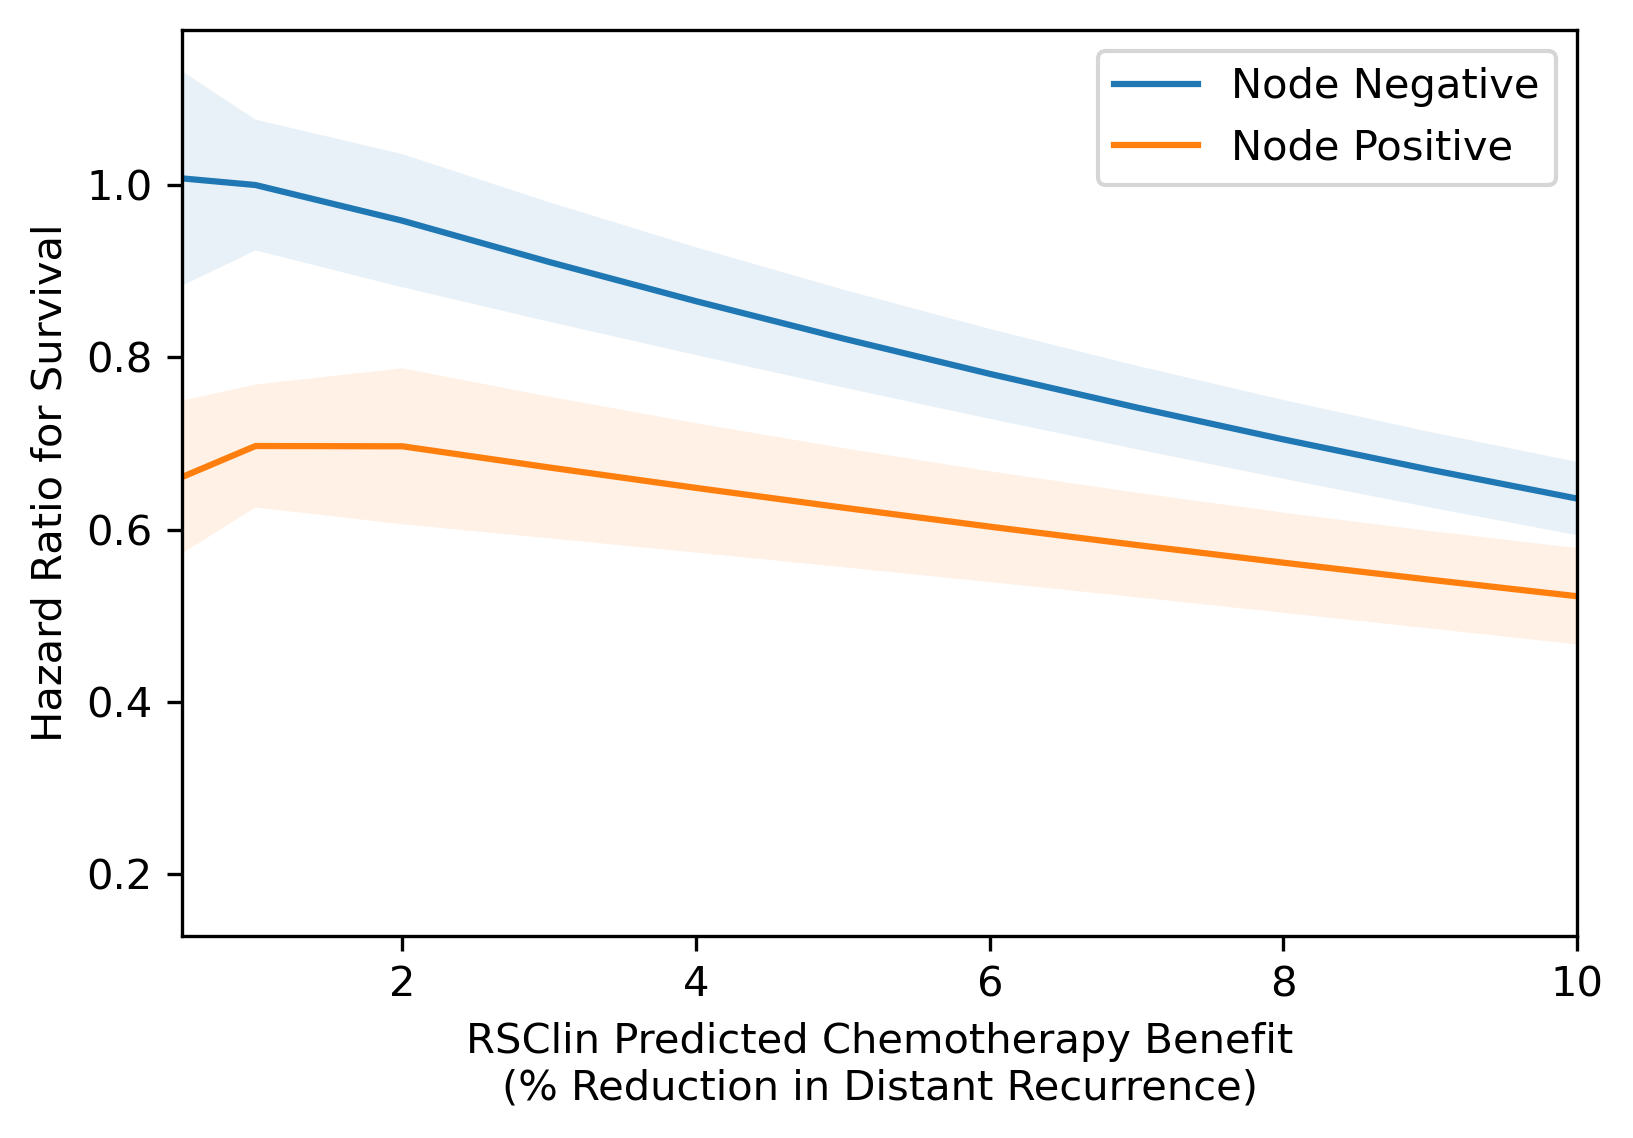

In [173]:
def rcs(x,knots,stub,norm=True,data=None):
    """Generate Kaplan Meier curves for survival in subgroups who received / didn't receive chemo

    Parameters
    ----------
    x - column from dataframe to generate spline
    knots - knots to use for spline
    stub - string to use as base for names of columns in spline
    norm  - to normalize by the square of the spacing between first and last knots
    data - if dataframe provided, will update with rows for knots
    """
    denom = knots[-1] - knots[-2]
    spline_li = []
    tot_knots = len(knots) - 2
    if norm:
        norm_val = (knots[-1] - knots[0])**2
    else:
        norm_val = 1
    for i in range(tot_knots):
        n1 = (knots[-1] - knots[i])/denom
        n2 = (knots[-2] - knots[i])/denom
        p1 = ((x - knots[i]).clip(0)**3)
        p2 = ((x - knots[-2]).clip(0)**3)*n1
        p3 = ((x - knots[-1]).clip(0)**3)*n2
        res = (p1 - p2 + p3)/norm_val
        spline_li.append(res)
    labels = [stub + str(i+1) for i in range(tot_knots)]
    if data is not None:
        for var,lab in zip(spline_li,labels):
            data[lab] = var
    else:
        res_df = pd.concat(spline_li,axis=1)
        res_df.columns = labels
        return res_df

knot_dict = {3: [0.1, 0.5, 0.9],
             4: [0.05, 0.35, 0.65, 0.95],
             5: [0.05, 0.275, 0.5, 0.725, 0.95],
             6: [0.05, 0.23, 0.41, 0.59, 0.77, 0.95],
             7: [0.025, 0.1833, 0.3417, 0.5, 0.6538, 0.8167, 0.975]}

def sug_knots(x,n):
    #Suggests n knots for data x
    if n < 3:
        print('Error, need n greater than 2')
        return -1
    elif n > 7:
        print('Error, need n less than 8')
        return -1
    else:
        loc_quants = knot_dict[n]
    for n in range(len(loc_quants)-1):
        l = list(x.quantile(loc_quants))
        while l[n] == l[n+1]:
            loc_quants[n+1] += 0.01
            l = list(x.quantile(loc_quants))
    return list(x.quantile(loc_quants))


def graphSpline3(df, column, ax, label, lb = 0, ub = 40, knots = 3, knotlist = None, covariates = []):
    """Graphs Cox Model with inputs RCS(column)*chemo, RCS(column), and chemo
    
    Parameters
    ----------
    df - dataframe to use for cox model
    column - column to use for spline generation
    ax - axis for graphing
    label - label for graph
    lb - lower bound for values in dataframe to include
    ub - upper bound for values in dataframe to include
    knots - number of knots to use
    knotlist - can provide a list of knots to use
    covariates - covariates to include in spline model
    """
    
    df = df[df[column] > lb]
    df = df[df[column] < ub]
    df = df.sort_values(column)
    if not knotlist:
        knotlist = sug_knots(df[column], knots)
    knots = len(knotlist)
    rcs(df[column], knotlist, 'rcs', data=df)
    df['rcs0'] = df[column]
    df['rcsc0'] = df[column] * df['chemo']
    colsvar = ['rcs0']
    colsvarchemo = ['rcsc0']
    for s in range(knots - 2):
        colsvar += ['rcs' + str(s+1)]
        colsvarchemo += ['rcsc' + str(s+1)]
        df['rcsc' + str(s+1)] = df['rcs' + str(s+1)] * df['chemo']
    print("Knots " + str(knotlist))
    cph = CoxPHFitter(penalizer = 0.00001)
    #cph.fit(df[colsvarchemo + ['chemo'] + colsvar + ['last_contact', 'alive'] + covariates],
    #        duration_col='last_contact', event_col='alive', step_size=0.001)
    cph.fit(df[colsvarchemo + ['chemo'] + colsvar + ['last_contact', 'alive', 'score_ACRI'] + covariates],
            duration_col='last_contact', event_col='alive', weights_col = 'score_ACRI')
    cis = cph.confidence_intervals_.values.tolist()
    hrs = cph.params_.values.tolist()
    ses = cph.standard_errors_.values.tolist()
    cl = []
    cu = []
    se = []
    b = []
    for s in range(knots):
        cl += [cis[s][0]]
        cu += [cis[s][1]]
        se += [ses[s]]
        b += [hrs[s]]
    cutoff = "NA"
    df['ones'] = 1
    colsvar += ['ones']
    b = np.array(b)
    se = np.array(se)

    covarM = np.array(cph.variance_matrix_.iloc[0:knots,0:knots].values.tolist())
    #delta method
    #covarp = np.sqrt((df[colsvar].values.dot(covarM) * (df[colsvar].values)).sum(axis = 1))
    d = np.exp(np.dot(df[colsvar], b))
    covarp = np.sqrt((np.multiply(df[colsvar].values,d[:,np.newaxis]).dot(covarM) * (np.multiply(df[colsvar].values,d[:,np.newaxis]))).sum(axis=1))
    for i,j,k in zip(df[column], d, covarp):
        if j+1.96*k < 1:
            cutoff = i
            break
    minV = 1
    maxV = 0
    minX = 1
    maxX = 0
    for i,j in zip(df[column], d):
        if j < minV:
            minV = j
            minX = i
        if j > maxV:
            maxV = j
            maxX = i
    print(cutoff)
    ax.plot(df[column], d, label =  label)
    ax.fill_between(df[column], d - 1.96 * covarp, d + 1.96 * covarp, alpha=.1)

def plotSplines(df1, df2, var, lb = -1, ub = 150, knots = 3, knotlist = None, covariates = []):
    #Function to generate a plot with two dataframes for node negative ande node positive patients
    fig, ax = plt.subplots(1,1, dpi = 300)
    graphSpline3(df1, var, ax, 'Node Negative', lb = lb, ub = ub, knots = knots, knotlist = knotlist, covariates = covariates)
    graphSpline3(df2, var, ax, 'Node Positive', lb = lb, ub = ub, knots = knots, knotlist = knotlist, covariates = covariates)
    ax.set_xlim([0.5,10])
    ax.set_ylabel('Hazard Ratio for Survival')
    ax.set_xlabel('RSClin Predicted Chemotherapy Benefit\n(% Reduction in Distant Recurrence)')
    ax.legend()
    fig.savefig("figure 5.png", bbox_inches="tight")
    plt.show()

df1 = prepareDataset(LN = 0)
df2 = prepareDataset(LN = 1)
plotSplines(df1.copy(), df2.copy(), 'absBenefitAI', -1, 31, 3, covariates = [], knotlist = [0.5, 1, 2]) #'age', 'cdcc', 'insurance', 'race_black', 'race_hispanic', 'race_other'])


# Plot Hazard Ratios for Subgroups

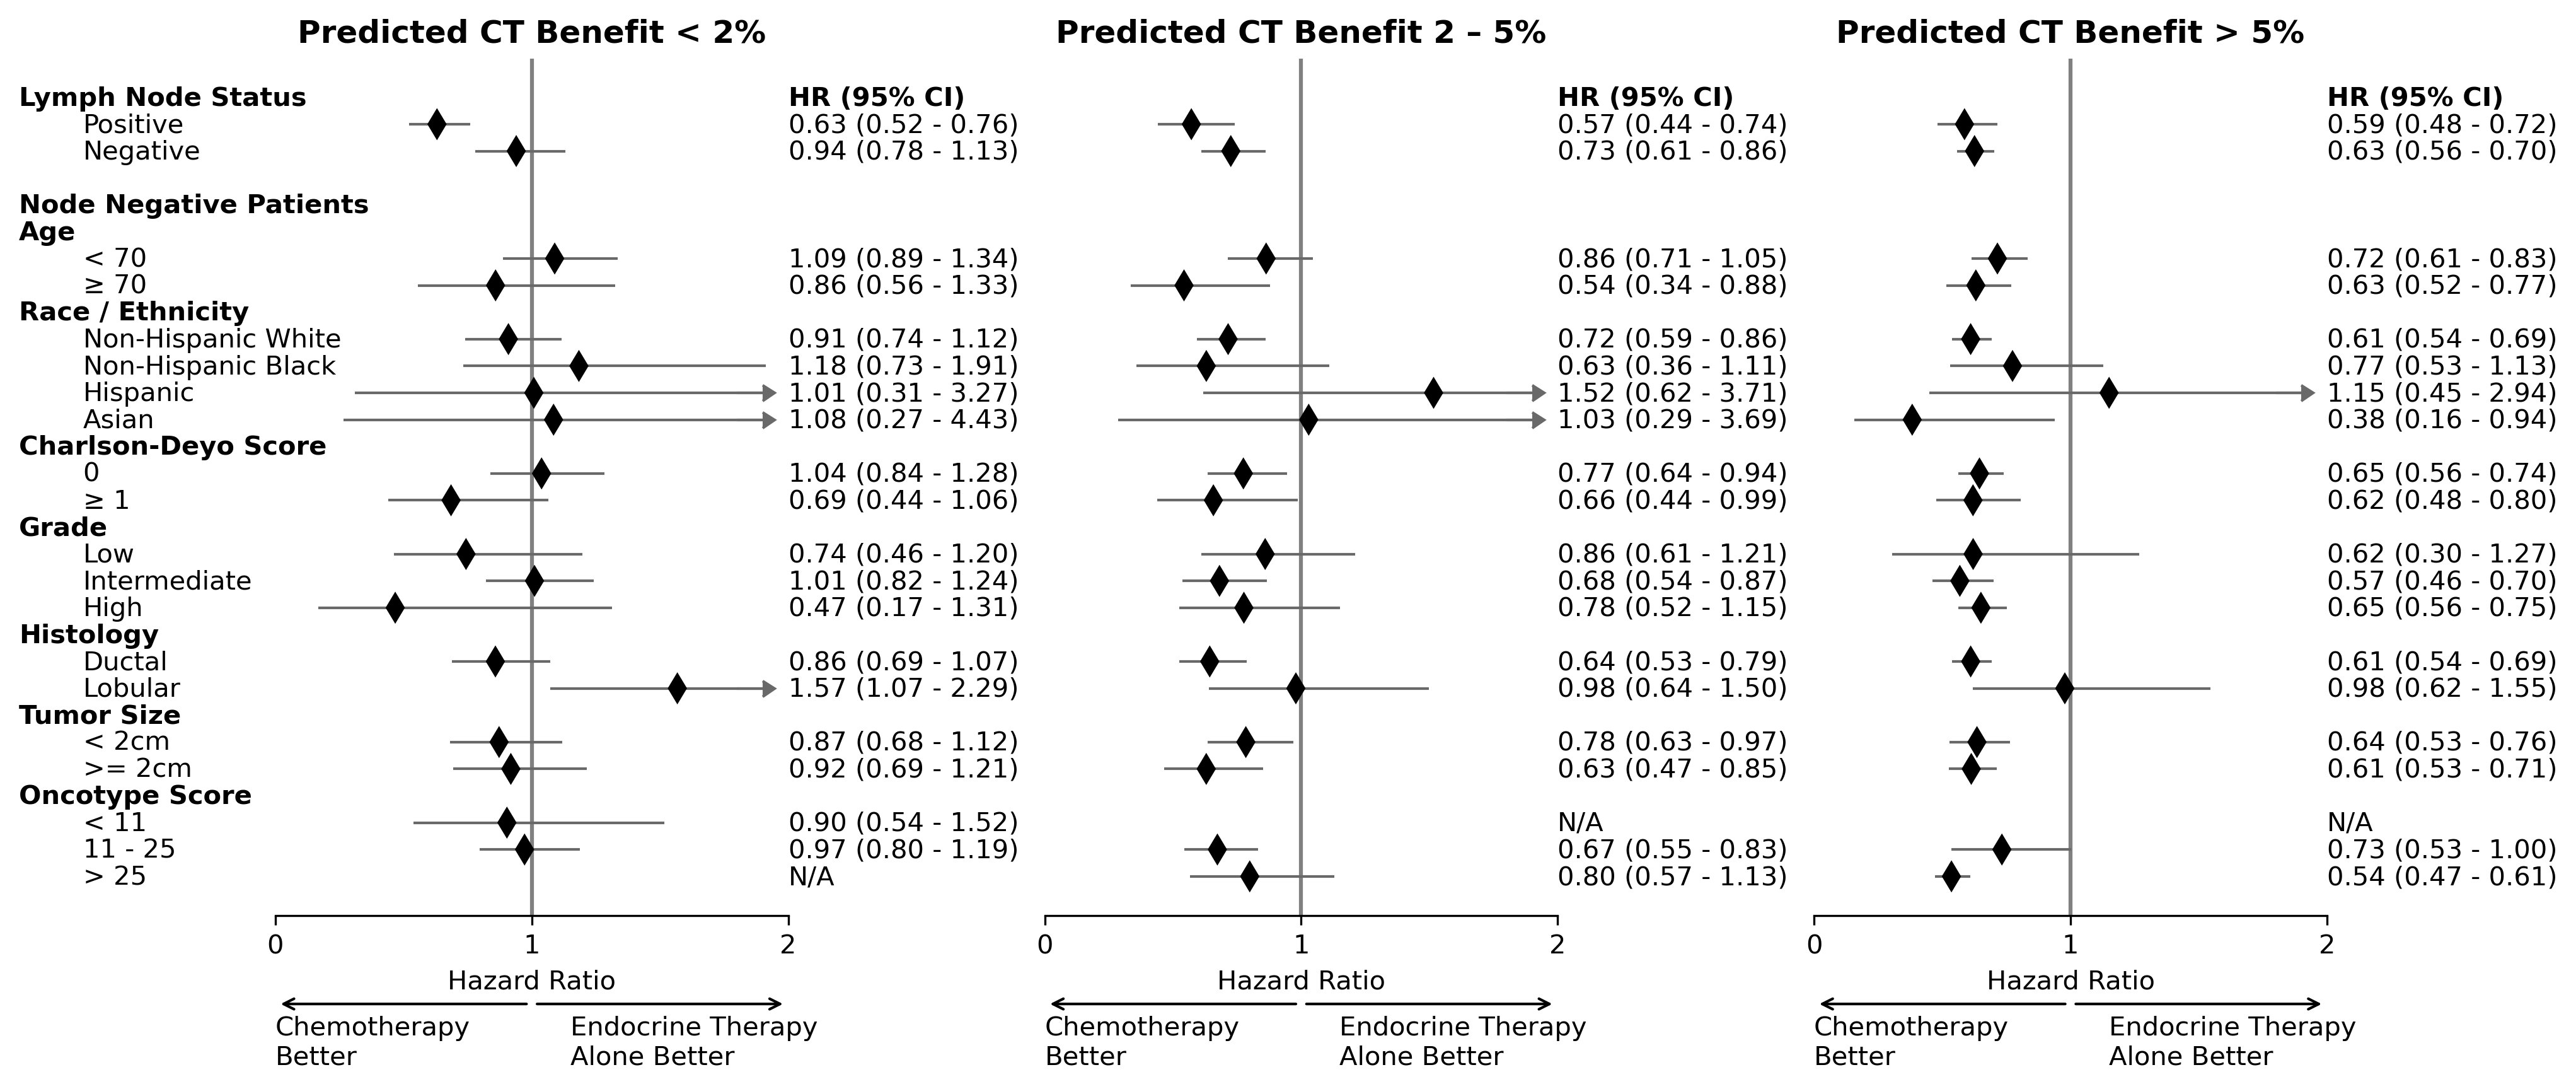

In [181]:
def getHRChemo(df, score = None, LN = 0, ageL = 0, ageU = 100, ethGroup = 4, riskLower = 0, riskUpper = 1000, cdcc = -1, grade = 0, histgroup = -1, TSL = 0, TSU = 1000, RSL = 0, RSU = 1000):
    """Get the HR, lower bound, and upper bound for survival with versus without chemotherapy in subgroups.
    
    Parameters
    ----------
    df - dataset to calculate HR for
    score - if weighted, provide propensity score
    LN - lymph node status (0 = negative, 1 = positive)
    ageL / ageU - upper and lower bound for patient's age, inclusive
    ethGroup - which races to include (0 - white, 1 - black, 2 - hispanic, 5 - asian)
    riskLower / riskUpper - lower and upper bound for abs benefit of AI
    cdcc - -1 for all, 0 for 0, or 1 for 1
    grade - 0 for all, or 1-3 for grades 1-3 only
    TSL / TSU - lower and upper bounds for tumor size
    RSL / RSU - lower and upper bounds for recurrence score

    Returns
    -------
    Tuple of hazard ratio, lower bound, and upper bound

    """
    if LN == 1:
        df = df[(df.regional_nodes_positive.astype(float) > 0) & (df.regional_nodes_positive.astype(float) < 98)]
    if LN == 0:
        df = df[(df.regional_nodes_positive.astype(float).isin([0.0,98.0,99.0]))]
    if ethGroup != 4:
        df = df[df.race_parse == ethGroup]
    if grade > 0:
        df = df[df.grade == grade]
    if cdcc > -1:
        if cdcc == 0:
            df = df[df.cdcc == 0]
        else:
            df = df[df.cdcc == 1]
    if histgroup > -1:
        df = df[df.histology == histgroup]
    df = df[(df.tumor_size >= TSL) & (df.tumor_size < TSU)]
    df = df[(df.recurrence_score >= RSL) & (df.recurrence_score < RSU)]
    df = df[(df.age.astype(float) >= ageL) & (df.age.astype(float) <= ageU)]
    df = df[(df.absBenefitAI > riskLower) & (df.absBenefitAI <= riskUpper)]
    if len(df.index) < 10:
        return 1, 1, 1
    if score:
        cph = CoxPHFitter().fit(df[['chemo', 'last_contact', 'alive'] + [score]], robust=True, duration_col='last_contact', event_col='alive', weights_col=score)
    else:
        cph = CoxPHFitter().fit(df[['chemo', 'last_contact', 'alive']], robust=True, duration_col='last_contact', event_col='alive')

    cis = cph.confidence_intervals_[cph.confidence_intervals_.index == 'chemo'].values.tolist()[0]
    ci1 = math.exp(cis[0])
    ci2 = math.exp(cis[1])
    hr = cph.hazard_ratios_['chemo']
    return hr, ci1, ci2

def getHRarray(score):
    """Get an array of HRs, LBs, and UBs for various clinical and demographic subgroups, print to console
    
    Parameters
    ----------
    score - match on score
    """
    
    df = prepareDataset(LN = 2, ageL = 0)
    LNs = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ageL =[0, 0, 0, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ageU = [200, 200, 69, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
    ethGroup = [4, 4, 4, 4, 0, 1, 2, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
    cdccGroup = [-1, -1, -1, -1, -1, -1,  -1, -1, 0, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    grade = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0]
    histgroup = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 1, -1, -1, -1, -1, -1] 
    TSL = [0, 0, 0 ,0 ,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0]
    TSU = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 20, 1000, 1000, 1000, 1000]
    RSL = [0, 0, 0 ,0 , 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 26]
    RSU = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 11, 26, 1000]
    labs = ["Overall LN+", "Overall LN-", "Age < 70", "Age >= 70", "Non-Hispanic White", "Non-Hispanic Black", "Hispanic", "Asian", "CDCC 0", "CDCC > 0", "Grade 1", "Grade 2", "Grade 3", "< 2cm", ">= 2cm", "Low RS", "Intermediate RS", "High RS"]
    rlList = [0, 1.99, 5.01]
    ruList = [1.99, 5, 1000]
    for rl, ru in zip(rlList ,ruList):
        hrs = []
        lbs = []
        ubs = []
        for a,b,c,d,e,f,g, t1,t2,r1,r2 in zip(LNs, ageL, ageU, ethGroup, cdccGroup, grade, histgroup, TSL, TSU, RSL, RSU):
            h,l,u = getHRChemo(df.copy(), score, LN = a, ageL = b, ageU = c, ethGroup = d, riskLower = rl, riskUpper = ru, cdcc =e, grade=f, histgroup = g, TSL=t1, TSU=t2, RSL=r1, RSU=r2)
            hrs += [h]
            lbs += [l]
            ubs += [u]
        print(labs)
        print(hrs)
        print(lbs)
        print(ubs)

def annotateForestOld(labs, ax, index, hrs):
    """Annotates the forest plot with specified row labels
    
    Parameters
    ----------
    labs - row labels
    ax - axis on which to annotate
    index - list of indexes to use for annotation
    hrs - list of hazard ratios / np.nan values. If nan, will annotate in bold (row heading)

    """
    for l, i, h in zip(labs, index, hrs):
        if np.isnan(h):
            ax.annotate(l, (-1, i-0.3), xycoords = 'data', clip_on=False, visible=True, zorder = 1, annotation_clip=False, weight='bold')
        else:
            ax.annotate(l, (-0.75, i-0.3), xycoords = 'data', clip_on=False, visible=True, zorder = 1, annotation_clip=False)

def forestPlot(ax, labs, hrs, lbs, ubs, axTitle, annotate = False):
    """Create a forest plot
    Parameters
    ----------
    ax - axis on which to annotate
    labs - row labels
    hrs - hazard ratios
    lbs - lower bounds
    ubs - upper bounds
    axTitle - title for forest plot
    annotate - should be True for leftmost plot to allow annotating with labels
    """
    nanArray = [1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
    hrs2 = []
    lbs2 = []
    ubs2 = []
    for i in nanArray:
        if i == 1:
            hrs2 += [np.nan]
            lbs2 += [np.nan]
            ubs2 += [np.nan]
        else:
            hrs2 += [hrs.pop(0)]
            lbs2 += [lbs.pop(0)]
            ubs2 += [ubs.pop(0)]
    hrs = hrs2
    lbs = lbs2
    ubs = ubs2
    for a,b,c,d in zip(hrs, lbs, ubs, list(range(len(hrs)))):
        if a == 1 and b == 1 and c == 1:
            hrs[d] = -1
            lbs[d] = -1
            ubs[d] = -1
    index = list(reversed(range(len(labs))))
    if annotate:
        annotateForestOld(labs, ax, index, hrs)
    ax.set_xlabel("Hazard Ratio")
    ax.annotate('Chemotherapy\nBetter', (0, -7), xycoords = 'data', clip_on=False, visible=True, zorder = 1, annotation_clip=False)
    ax.annotate('Endocrine Therapy\nAlone Better', (1.15, -7), xycoords = 'data', clip_on=False, visible=True, zorder = 1, annotation_clip=False)
    extend_lb = []
    extend_ub = []
    extend_hr = []
    new_ubs = []
    lims_ar = []
    for lb, ub in zip(lbs, ubs):
        if ub > 2.0:
            new_ubs += [1.9]
            extend_lb += [1.8]
            extend_ub += [1.9]
            extend_hr += [1.8]
            lims_ar += [True]
        else:
            new_ubs += [ub]
            extend_lb += [1.0]
            extend_ub += [1.0]
            extend_hr += [1.0]
            lims_ar += [False]
            
    ax.errorbar(hrs, index, xerr=[[a_i - b_i for a_i, b_i in zip(hrs, lbs)], [a_i - b_i for a_i, b_i in zip(new_ubs, hrs)]], marker='None', zorder=2, ecolor="dimgrey", elinewidth=1, linewidth=0)
    ax.errorbar(extend_hr, index, xerr=[[a_i - b_i for a_i, b_i in zip(extend_hr, extend_lb)], [a_i - b_i for a_i, b_i in zip(extend_ub, extend_hr)]], marker='None', ls='--', zorder=2, ecolor="dimgrey", elinewidth=1, linewidth=0, xlolims=lims_ar)
    ax.scatter(hrs, index, c="k", s=(75), marker='d', zorder=3, edgecolors='None')
    
    ax.axvline(1, color="gray", zorder=1)
    ax.set_title(axTitle, fontweight='bold')
    offset = 2
    ax.annotate('HR (95% CI)', (offset, 29 - 0.3), xycoords='data', clip_on=False,
                visible=True, zorder=1, annotation_clip=False, weight = 'bold')
    for i, h, l, u in zip(index, hrs, lbs, ubs):
        if not np.isnan(h):
            if h != -1:
                ax.annotate('{0:.2f} ({1:.2f} - {2:.2f})'.format(h, l, u), (offset, i-0.3),  xycoords = 'data', clip_on=False, visible=True, zorder = 1, annotation_clip=False)
            else:
                ax.annotate('N/A', (offset, i - 0.3), xycoords='data',
                            clip_on=False, visible=True, zorder=1, annotation_clip=False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.set_yticks([])
    ax.set_xlim([0.2, 0.8])
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels([0, 1, 2])
    ax.annotate("", xy=(0, -4.75), xytext=(1,-4.75), arrowprops=dict(arrowstyle="->"), zorder = 1, annotation_clip=False)
    ax.annotate("", xy=(2, -4.75), xytext=(1,-4.75), arrowprops=dict(arrowstyle="->"), zorder = 1, annotation_clip=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

def getHRarraySaved():
    #Plot a pregenerated set of arrays of hazard ratios (as generation takes a long time)
    labs = ['Lymph Node Status', 'Positive', 'Negative', '', 'Node Negative Patients', 'Age', '< 70', '≥ 70', 'Race / Ethnicity', 'Non-Hispanic White', 'Non-Hispanic Black', 'Hispanic', 'Asian', 'Charlson-Deyo Score', '0', '≥ 1',
     'Grade', 'Low', 'Intermediate', 'High', 'Histology', 'Ductal', 'Lobular', 'Tumor Size', '< 2cm', '>= 2cm', 'Oncotype Score', '< 11', '11 - 25', '> 25']
    plt.figure(figsize=(14, 6), dpi=300)
    gspec = gridspec.GridSpec(1, 3, wspace=0.5)  # sets up grid

    hrs = [0.5866781426427455, 0.6257886423355783, 0.7150407601930344, 0.6309579658749359, 0.6107042539317166, 0.7738966798512671, 1.1504286720660453, 0.3827353994571194, 0.6450475851721802, 0.6197955688303505, 0.6203665525536266, 0.5684751931295724, 0.6507133983805341, 0.610746114211119, 0.9779019727708061, 0.6352443165335234, 0.6130012349960977, 1, 0.7324680830207794, 0.535730326173997]
    lbs = [0.4812504148503307, 0.5566305018058855, 0.6131672271804951, 0.5169851001279457, 0.5386483646666884, 0.5306855452935618, 0.45021587837283966, 0.15614139142002867, 0.5618765126516062, 0.47738422602752817, 0.3034926989482553, 0.46113281402457995, 0.5633363397233179, 0.5387672660263889, 0.6186021448496035, 0.5283273905212076, 0.5267177792863138, 1, 0.5348778010378403, 0.47164153832391187]
    ubs = [0.7152019664477285, 0.7035392843290027, 0.8338398826180717, 0.770056921567974, 0.6923991795669504, 1.1285705374799861, 2.939670040725705, 0.9381649840915312, 0.7405299523428508, 0.8046904907988855, 1.2680853966536054, 0.7008047039274001, 0.7516431960343797, 0.6923412752505851, 1.5458922609806518, 0.7637978816317776, 0.7134190811175928, 1, 1.0030505876353981, 0.6085277887152252]
    ax3 = plt.subplot(gspec[0, 2])
    forestPlot(ax3, labs, hrs, lbs, ubs, "Predicted CT Benefit > 5%")

    hrs = [0.5718656333287773, 0.7256944789419025, 0.8634661218698766, 0.5432277042285444, 0.7151966708570271, 0.6301593248735404, 1.5164636265417046, 1.029400930411539, 0.7747335245277875, 0.657785478375856, 0.8596283628515791, 0.6815106867786165, 0.7767192843398941, 0.6434710123793653, 0.9793540486851932, 0.7843078869792075, 0.6299415670378314, 1, 0.6733628851285229, 0.7995122841154977]
    lbs = [0.44195267481833866, 0.6106250252385158, 0.7128031980629441, 0.336023849290292, 0.5929815056361947, 0.35816244605643555, 0.6192254779103465, 0.2870684937135549, 0.6359033170281632, 0.4379480271498361, 0.6106432620859845, 0.5365351031987435, 0.5235843831198022, 0.5256177090739654, 0.6401407581147837, 0.6349325584203093, 0.46634654479461074, 1, 0.5454653191239088, 0.5664556945101064]
    ubs = [0.7399667910527905, 0.8624482374613651, 1.0459741842392334, 0.8782005779193377, 0.8626007272456039, 1.1087169498013345, 3.713771497879115, 3.6913360356065668, 0.9438730982443759, 0.9879750763533397, 1.2101352264079075, 0.8656596994762097, 1.1522361363620675, 0.7877492265281705, 1.4983178941780446, 0.9688255129146851, 0.8509259526236004, 1, 0.8312491356863133, 1.1284552325039354]
    ax2 = plt.subplot(gspec[0, 1])
    forestPlot(ax2, labs, hrs, lbs, ubs, "Predicted CT Benefit 2 – 5%")

    hrs = [0.6302205215227458, 0.9393388511852442, 1.089230929884092, 0.8586282452548698, 0.9087802503116983, 1.1836104009110977, 1.0079912673700437, 1.0847777880688017, 1.038023290056346, 0.6850551880493714, 0.7434407156742541, 1.0104711328424136, 0.4674439902979768, 0.8580852016070051, 1.5675536519156257, 0.8723734030295953, 0.9181985969675717, 0.9029396562825964, 0.9717396769546932, 1]
    lbs = [0.5220024374570251, 0.7803273546252213, 0.8883748981946824, 0.5561484302265485, 0.7391859394514039, 0.7328349509674501, 0.31083097388396, 0.2656858023020963, 0.8393019005884221, 0.44113850221062934, 0.4611818358765776, 0.8221125426668227, 0.16646462845069265, 0.6875279672136375, 1.0728065946860121, 0.6803081342322912, 0.6943828956637395, 0.5377964614559914, 0.7957915021195467, 1]
    ubs = [0.7608736612098677, 1.130752974525411, 1.335499259408572, 1.325621764767257, 1.1172852448594075, 1.9116631641210493, 3.2688067807347267, 4.429076899447694, 1.2837959141329087, 1.063839606657783, 1.1984515753351634, 1.241985564404206, 1.3126144941381137, 1.0709531078437404, 2.2904635968920313, 1.1186627294589737, 1.2141552862809708, 1.516001092086863, 1.1865897000068224, 1]
    ax = plt.subplot(gspec[0, 0])
    forestPlot(ax, labs, hrs, lbs, ubs, "Predicted CT Benefit < 2%", True)
    plt.savefig('Figure 4.png', bbox_inches = "tight")
    plt.show()

getHRarray("score_ACRI")
getHRarraySaved()
